In [1]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
import numpy as np
import math

In [2]:
iris = datasets.load_iris()

In [3]:
type( iris )

sklearn.utils.Bunch

In [4]:
for key in iris.keys():
    print( key )

data
target
frame
target_names
DESCR
feature_names
filename


In [5]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [6]:
iris.target.size

150

In [7]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [8]:
iris.target.size

150

In [9]:
X = iris.data[50:150, 0:2] # we only take the first two features of two target (eliminate the 'setosa')

X.shape

(100, 2)

In [10]:
Y = iris.target[0:100]
Y.size

100

In [11]:
def sigmoid(x):
    """The logistic sigmoid function"""
    return 1 / (1 + np.exp(-x))

In [38]:
#source: https://github.com/ddbourgin/numpy-ml/blob/master/numpy_ml/linear_models/lm.py
class LogisticRegression_new:
    def __init__(self, gamma=0, penalty="l2", fit_intercept=True):
        r"""
        A simple logistic regression model fit via gradient descent on the
        penalized negative log likelihood.
        Notes
        -----
        For logistic regression, the penalized negative log likelihood of the
        targets **y** under the current model is
        .. math::
            - \log \mathcal{L}(\mathbf{b}, \mathbf{y}) = -\frac{1}{N} \left[
                \left(
                    \sum_{i=0}^N y_i \log(\hat{y}_i) +
                      (1-y_i) \log(1-\hat{y}_i)
                \right) - R(\mathbf{b}, \gamma) 
            \right]
        
        where
        
        .. math::
        
            R(\mathbf{b}, \gamma) = \left\{
                \begin{array}{lr}
                    \frac{\gamma}{2} ||\mathbf{beta}||_2^2 & :\texttt{ penalty = 'l2'}\\
                    \gamma ||\beta||_1 & :\texttt{ penalty = 'l1'}
                \end{array}
                \right.
                
        is a regularization penalty, :math:`\gamma` is a regularization weight, 
        `N` is the number of examples in **y**, and **b** is the vector of model 
        coefficients.
        Parameters
        ----------
        penalty : {'l1', 'l2'}
            The type of regularization penalty to apply on the coefficients
            `beta`. Default is 'l2'.
        gamma : float
            The regularization weight. Larger values correspond to larger
            regularization penalties, and a value of 0 indicates no penalty.
            Default is 0.
        fit_intercept : bool
            Whether to fit an intercept term in addition to the coefficients in
            b. If True, the estimates for `beta` will have `M + 1` dimensions,
            where the first dimension corresponds to the intercept. Default is
            True.
        """
        err_msg = "penalty must be 'l1' or 'l2', but got: {}".format(penalty)
        assert penalty in ["l2", "l1"], err_msg
        self.beta = None
        self.gamma = gamma
        self.penalty = penalty
        self.fit_intercept = fit_intercept

    def fit(self, X, y, gamma, rmsprop, lr=0.1, tol=1e-7, max_iter=1e7):
        """
        Fit the regression coefficients via gradient descent on the negative
        log likelihood.
        Parameters
        ----------
        X : :py:class:`ndarray <numpy.ndarray>` of shape `(N, M)`
            A dataset consisting of `N` examples, each of dimension `M`.
        y : :py:class:`ndarray <numpy.ndarray>` of shape `(N,)`
            The binary targets for each of the `N` examples in `X`.
        lr : float
            The gradient descent learning rate. Default is 1e-7.
        max_iter : float
            The maximum number of iterations to run the gradient descent
            solver. Default is 1e7.
        """
        # convert X to a design matrix if we're fitting an intercept
        if self.fit_intercept:
            X = np.c_[np.ones(X.shape[0]), X]

        l_prev = np.inf
        self.beta = np.random.rand(X.shape[1])
        for _ in range(int(max_iter)):
            y_pred = sigmoid(np.dot(X, self.beta))
            loss = self._NLL(X, y,gamma, y_pred)
            if l_prev - loss < tol:
                return
            l_prev = loss
            if rmsprop == 1:
                self.beta -= lr * math.sqrt(np.mean((self._NLL_grad(X, y, gamma, y_pred))**2))
            else:
                self.beta -= lr * self._NLL_grad(X, y,gamma, y_pred)
        
    def _NLL(self, X, y,gamma, y_pred):
        r"""
        Penalized negative log likelihood of the targets under the current
        model.
        .. math::
            \text{NLL} = -\frac{1}{N} \left[
                \left(
                    \sum_{i=0}^N y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i)
                \right) - R(\mathbf{b}, \gamma)
            \right]
        """
        N, M = X.shape
        beta = self.beta 
        order = 2 if self.penalty == "l2" else 1
        norm_beta = np.linalg.norm(beta, ord=order)
        
        nll = -np.log(y_pred[y == 1]).sum() - np.log(1 - y_pred[y == 0]).sum()
        penalty = (gamma / 2) * norm_beta ** 2 if order == 2 else gamma * norm_beta
        return (penalty + nll) / N

    def _NLL_grad(self, X, y, gamma, y_pred):
        """Gradient of the penalized negative log likelihood wrt beta"""
        N, M = X.shape
        l1norm = lambda x: np.linalg.norm(x, 1)  # noqa: E731
        p, beta = self.penalty, self.beta
        d_penalty = gamma * beta if p == "l2" else gamma * np.sign(beta)
        return -(np.dot(y - y_pred, X) + d_penalty) / N
    

    def predict(self, X):
        """
        Use the trained model to generate prediction probabilities on a new
        collection of data points.
        Parameters
        ----------
        X : :py:class:`ndarray <numpy.ndarray>` of shape `(Z, M)`
            A dataset consisting of `Z` new examples, each of dimension `M`.
        Returns
        -------
        y_pred : :py:class:`ndarray <numpy.ndarray>` of shape `(Z,)`
            The model prediction probabilities for the items in `X`.
        """
        # convert X to a design matrix if we're fitting an intercept
        if self.fit_intercept:
            X = np.c_[np.ones(X.shape[0]), X]
        return sigmoid(np.dot(X, self.beta))

                     

In [39]:
model = LogisticRegression_new()

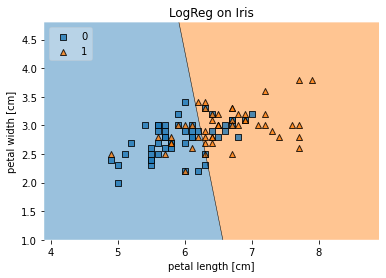

In [40]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn import datasets


gamma=0 #GD

model.fit( X, Y, gamma, rmsprop=0 )


# Plotting decision regions
plot_decision_regions(X, Y, clf=model, legend=2)

# Adding axes annotations
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.title('LogReg on Iris')
plt.show()

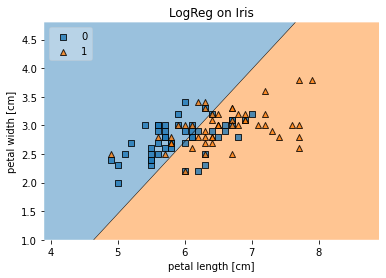

In [42]:
gamma=0.9 #Nesterov momentum

model.fit( X, Y, gamma, rmsprop=0 )


# Plotting decision regions
plot_decision_regions(X, Y, clf=model, legend=2)

# Adding axes annotations
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.title('LogReg on Iris')
plt.show()

## 

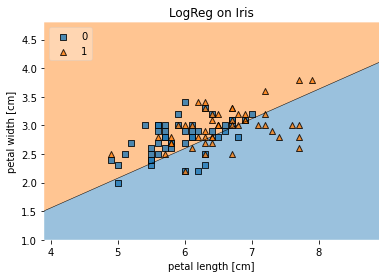

In [43]:

gamma=0 #GD

model.fit( X, Y, gamma, rmsprop=1 ) #RMSProp = True


# Plotting decision regions
plot_decision_regions(X, Y, clf=model, legend=2)

# Adding axes annotations
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.title('LogReg on Iris')
plt.show()